## Regressão Estruturada Para Previsão de Circunferência da Cabeça de Fetos

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


### Bibliotecas

In [2]:
# Imports
import os
import numpy as np 
import pandas as pd 
import torch
import skimage
import sklearn
from torchvision import transforms, datasets, models
from torch.utils.data.dataset import Dataset
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
from torch import optim, cuda
import matplotlib.pyplot as plt
from skimage import io, transform
from sklearn.model_selection import train_test_split
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
from timeit import default_timer as timer
plt.ion() 

In [3]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Júlio Monteiro" --iversions

Author: Júlio Monteiro

sklearn    : 1.0.2
torchvision: 0.8.0
pandas     : 1.0.3
numpy      : 1.18.5
matplotlib : 3.3.4
PIL        : 9.0.0
skimage    : 0.19.1
torch      : 1.7.0



### GPU

In [4]:
# Se GPU disponível, faremos o trainamento em GPU
train_on_gpu = cuda.is_available()
print(f'Treinamento em GPU: {train_on_gpu}')

Treinamento em GPU: True


### Carga, Análise e Manipulação de Dados

In [5]:
# Diretórios de dados
dir_imagens = '/media/datasets/IAMED/Cap07/dados/training_set/'
dir_csv = '/media/datasets/IAMED/Cap07/dados/training_set_pixel_size_and_HC.csv'

In [6]:
# Carrega o arquivo csv
dataset = pd.read_csv(os.path.join(dir_csv))

In [7]:
# Shape
dataset.shape

(999, 3)

In [8]:
# Visualiza
dataset.head()

,filename,pixel size(mm),head circumference (mm)
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [9]:
# Renomeia as colunas
dataset = dataset[['filename', 'pixel size(mm)', 'head circumference (mm)']].copy().rename(columns = {'pixel size(mm)':'pixel_size',
                                                                                                      'head circumference (mm)':'HC'})


In [10]:
# Visualiza
dataset.head()

,filename,pixel_size,HC
0,000_HC.png,0.069136,44.30
1,001_HC.png,0.089659,56.81
2,002_HC.png,0.062033,68.75
3,003_HC.png,0.091291,69.00
4,004_HC.png,0.061240,59.81


In [11]:
# Retorna tudo que tiver _HC (evita problemas com arquivos ocultos ou de cache)
dataset = dataset[dataset.filename.str.contains("_HC")]

In [12]:
# Resumo estatístico
dataset.describe()

,pixel_size,HC
count,806.000000,806.000000
mean,0.138848,173.971600
std,0.051949,64.761672
min,0.049415,44.300000
25%,0.108393,153.925000
50%,0.128191,174.225000
75%,0.157101,188.797500
max,0.393280,346.400000


(array([1]), [Text(1, 0, 'HC')])

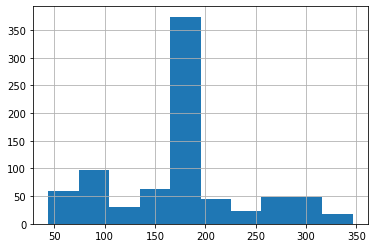

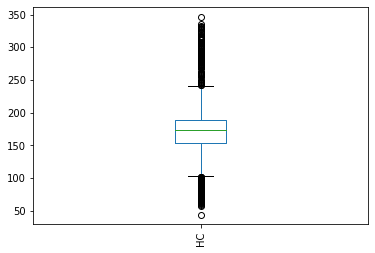

In [13]:
# Plot do histograma da coluna HC (Análise de Imagens Biomédicas)
dataset['HC'].hist(bins = 10)
columns = ['HC']
dataset[columns].plot.box()
plt.xticks(rotation = 'vertical')

### Divisão em Treino e Teste

In [14]:
# Dados de treino e teste
train_df, test_val = train_test_split(dataset, test_size = 0.3, random_state = 2020)
valid_df, test_df = train_test_split(test_val, test_size = 0.5, random_state = 2020)

In [15]:
print('Dados de Treino:', train_df.shape[0], 
      '\nDados de Validação:', valid_df.shape[0], 
      '\nDados de Teste',test_df.shape[0])

Dados de Treino: 564 
Dados de Validação: 121 
Dados de Teste 121


In [16]:
# Salva os dados em discoo
train_df.to_csv("dados/train_file.csv", index = False, encoding = 'utf8')
valid_df.to_csv("dados/val_file.csv", index = False, encoding = 'utf8')
test_df.to_csv("dados/test_file.csv", index = False, encoding = 'utf8')

### Transformação das Imagens

### Classe Para Formatação do Dataset

Conjunto de dados de estimativa de circunferência da cabeça.

In [17]:
# Classe
class HC_18(Dataset):

    # Método construtor
    def __init__(self, csv_file, root_dir, transform = None):
        self.HC_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    # Tamanho do dataset
    def __len__(self):
        return len(self.HC_df)

    # Obtém um item
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        # Extrai o nome da imagem e as features
        img_name = os.path.join(self.root_dir, self.HC_df.iloc[idx, 0])
        image = Image.open(img_name)
        features = self.HC_df.loc[idx,'HC']
        
        # Aplica transformação
        if self.transform:
            image = self.transform(image)
            
        return image , torch.tensor(features / 346.4)

In [18]:
# Hiperparâmetros
earlyStop = 250
epochsNo = 250
img_size = 224
cropped_img = 224
batch_size = 100
taxa_aprendizado = 0.0001

In [19]:
# Transformações das imagens
image_transforms = {
    
    # Usaremos dataset augmentation somente para os dados de treino
    'train':
        transforms.Compose([
            transforms.Grayscale(num_output_channels = 3),
            transforms.Resize(size = img_size),
            transforms.RandomRotation(degrees = 10),
            transforms.RandomHorizontalFlip(),
            transforms.CenterCrop(size = cropped_img),  
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),

    # Validação não usa dataset augmentation
    'val':
        transforms.Compose([
            transforms.Grayscale(num_output_channels = 3),
            transforms.Resize(size = img_size),
            transforms.CenterCrop(size = cropped_img),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
    
    # Teste não usa dataset augmentation
    'test':
        transforms.Compose([
            transforms.Grayscale(num_output_channels = 3),
            transforms.Resize(size = img_size),
            transforms.CenterCrop(size = cropped_img),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])}

### Dataloader

In [20]:
# Carrega os arquivos
train_filename = 'dados/train_file.csv'
val_filename = 'dados/val_file.csv'
test_filename = 'dados/test_file.csv'

In [21]:
# Dataset final
data = {'train': HC_18(train_filename, root_dir = dir_imagens, transform = image_transforms['train']),
        'val': HC_18(val_filename, root_dir = dir_imagens, transform = image_transforms['val']),
        'test': HC_18(test_filename, root_dir = dir_imagens, transform = image_transforms['test'])}

In [22]:
# Dataloader 
dataloaders = {'train': DataLoader(data['train'], batch_size = batch_size, shuffle = True),
               'val': DataLoader(data['val'], batch_size = batch_size, shuffle = False),
               'test': DataLoader(data['test'], batch_size = len(test_df), shuffle = False)}

torch.Size([100, 3, 224, 224]) torch.Size([100])


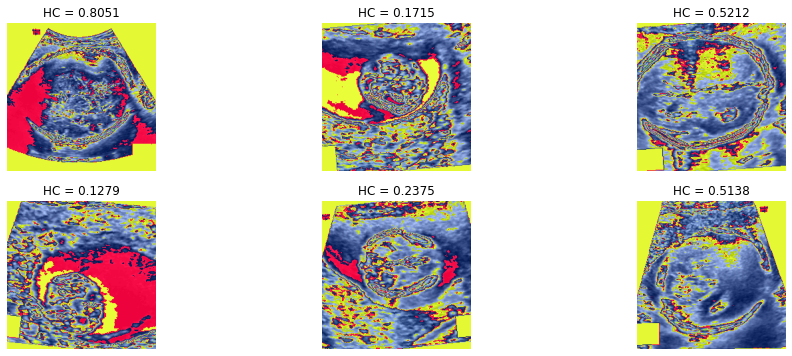

In [23]:
# Plot
trainiter = iter(dataloaders['train'])
t_x, t_y = next(trainiter)
print(t_x.shape, t_y.shape)
fig, m_axs = plt.subplots(2, 3, figsize = (16, 6))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    trans=transforms.ToPILImage(mode= None)
    c_ax.imshow(trans(c_x))
    c_ax.set_title('HC = {:.4f}'.format(c_y.numpy()))
    c_ax.axis('off')

### Modelo - CNN-Based Structured Regression

Estamos usando Transfer Learning.

In [24]:
# Modelo resnet50 pré-treinado
modelo = models.resnet50(pretrained = True)

In [25]:
# Número de inputs
n_inputs = modelo.fc.in_features
n_inputs

2048

In [26]:
# Adiciona a camada de regressão ao final do modelo CNN
modelo.fc = nn.Sequential(nn.Dropout(0.3), nn.Linear(n_inputs, 1 , bias = True))

In [27]:
print(modelo)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [28]:
# Se usamos GPU, enviamos o modelo para a GPU
if train_on_gpu:
    modelo = modelo.to('cuda')

In [29]:
# Modelo final
save_file_name = 'modelos/resnet50-transfer.pt'

### Treinamento do Modelo

Aplicando early stopping para evitar overfitting.

In [30]:
# Função de treinamento
def treina_modelo(model, 
                  criterion,
                  optimizer,
                  train_loader,
                  valid_loader,
                  save_file_name,
                  max_epochs_stop = 3,
                  n_epochs = 50,
                  print_every = 1):

    # Inicialização do early stopping
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    valid_max_acc = 0
    history = []

    try:
        print(f'O modelo foi treinado por: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Iniciando o treinamento...\n')

    overall_start = timer()

    ##### Loop principal #####
    for epoch in range(n_epochs):

        # Inicializa os contadores
        train_loss = 0.0
        valid_loss = 0.0

        # Coloca o modelo em modo de treinamento
        model.train()
        
        # Timer
        start = timer()

        ##### Loop de treinamento #####
        for ii, (data, target) in enumerate(train_loader):

            # Se usamos GPU, buscamos os dados e modelo na GPU
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()

            # Zera os gradientes
            optimizer.zero_grad()
            
            # As saídas previstas são logs de probabilidades 
            output = model(data)
            
            # Erro e backpropagation dos gradientes
            loss = criterion(output, target.float())
            loss.backward()

            # Atualiza os parâmetros
            optimizer.step()

            # Rastreia a perda de treino multiplicando a perda média pelo número de exemplos em lote
            train_loss += loss.item() * data.size(0)

            # Treinamento
            print( f'Epoch: {epoch+1}\t{100 * (ii + 1) / len(train_loader):.2f}% completo. {timer() - start:.2f} segundos na epoch.', end = '\r')

        ##### Após o treinamento começa a validação #####
        else:
            model.epochs += 1

            # Não precisamos do track dos gradientes
            with torch.no_grad():
                
                # Modo de avaliação
                model.eval()

                # Loop de validação
                for data, target in valid_loader:
                    
                    # Busca dados e modelo na GPU
                    if train_on_gpu:
                        data, target = data.cuda(), target.cuda()

                    # Forward pass
                    output = model(data)

                    # Erro de validação
                    loss = criterion(output, target.float())
                    
                    # Multiplica a perda média pelo número de exemplos em lote
                    valid_loss += loss.item() * data.size(0)
                    
                # Calcula o erro médio
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Grava o history
                history.append([train_loss, valid_loss])
                
                # Print 
                if (epoch + 1) % print_every == 0:
                    print(f'\nEpoch: {epoch+1} \tErro em Treinamento: {train_loss:.4f} \t\tErro em Validação: {valid_loss:.4f}')

                # Salva o modelo se a perda de validação diminuir
                if valid_loss < valid_loss_min:
                    
                    # Salva o modelo
                    torch.save(model.state_dict(), save_file_name)
                    
                    # Verifica se houve melhora
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    best_epoch = epoch

                # Caso contrário, incremente a contagem de épocas sem melhora
                else:
                    epochs_no_improve += 1
                    
                    # Dispara o early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        
                        print(f'\nEarly Stopping! Total epochs: {epoch+1}. Best epoch: {best_epoch+1} com loss: {valid_loss_min:.2f}')
                        total_time = timer() - overall_start
                        print(f'{total_time:.2f} segundos de tempo total. {total_time / (epoch+1):.2f} segundos por epoch.')

                        # Carregue o melhor dict de estado
                        model.load_state_dict(torch.load(save_file_name))
                        
                        # Adiciona o otimizador
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(history,columns=['train_loss', 'valid_loss'])
                        return model, history

    # Adiciona o otimizador
    model.optimizer = optimizer
    
    # Registra o tempo geral e imprima as estatísticas
    total_time = timer() - overall_start
    print(f'\nBest epoch: {best_epoch + 1} com loss: {valid_loss_min:.2f}')
    print(f'{total_time:.2f} segundos de tempo total. {total_time / (epoch + 1):.2f} segundos por epoch.')
    
    # Format history
    history = pd.DataFrame(history, columns = ['train_loss', 'valid_loss'])
    
    print(f'Treinamento Concluído!\n')
    
    return model, history

### Função de Perda e Otimizador

In [31]:
# Função de Perda e Otimizador
criterion = nn.MSELoss()
optimizer = optim.Adam(modelo.parameters(), lr = taxa_aprendizado)

In [32]:
%%time
modelo, history = treina_modelo(modelo, 
                                criterion, 
                                optimizer,
                                dataloaders['train'],
                                dataloaders['val'],
                                save_file_name = save_file_name,
                                max_epochs_stop = earlyStop,
                                n_epochs = epochsNo,
                                print_every = 1)

# Salva o histórico
history.to_csv("dados/history.csv", index = False, encoding = 'utf8')

Iniciando o treinamento...

Epoch: 1	100.00% completo. 8.16 segundos na epoch.
Epoch: 1 	Erro em Treinamento: 0.3137 		Erro em Validação: 0.4019
Epoch: 2	100.00% completo. 8.18 segundos na epoch.
Epoch: 2 	Erro em Treinamento: 0.1223 		Erro em Validação: 0.3688
Epoch: 3	100.00% completo. 8.11 segundos na epoch.
Epoch: 3 	Erro em Treinamento: 0.0907 		Erro em Validação: 0.1247
Epoch: 4	100.00% completo. 8.11 segundos na epoch.
Epoch: 4 	Erro em Treinamento: 0.0778 		Erro em Validação: 0.0403
Epoch: 5	100.00% completo. 8.12 segundos na epoch.
Epoch: 5 	Erro em Treinamento: 0.0692 		Erro em Validação: 0.0375
Epoch: 6	100.00% completo. 8.11 segundos na epoch.
Epoch: 6 	Erro em Treinamento: 0.0688 		Erro em Validação: 0.0534
Epoch: 7	100.00% completo. 8.15 segundos na epoch.
Epoch: 7 	Erro em Treinamento: 0.0636 		Erro em Validação: 0.0458
Epoch: 8	100.00% completo. 8.12 segundos na epoch.
Epoch: 8 	Erro em Treinamento: 0.0603 		Erro em Validação: 0.0423
Epoch: 9	100.00% completo. 8.15 segu

Epoch: 70	100.00% completo. 8.10 segundos na epoch.
Epoch: 70 	Erro em Treinamento: 0.0402 		Erro em Validação: 0.0277
Epoch: 71	100.00% completo. 8.15 segundos na epoch.
Epoch: 71 	Erro em Treinamento: 0.0399 		Erro em Validação: 0.0278
Epoch: 72	100.00% completo. 8.12 segundos na epoch.
Epoch: 72 	Erro em Treinamento: 0.0406 		Erro em Validação: 0.0276
Epoch: 73	100.00% completo. 8.14 segundos na epoch.
Epoch: 73 	Erro em Treinamento: 0.0398 		Erro em Validação: 0.0277
Epoch: 74	100.00% completo. 8.10 segundos na epoch.
Epoch: 74 	Erro em Treinamento: 0.0397 		Erro em Validação: 0.0276
Epoch: 75	100.00% completo. 8.12 segundos na epoch.
Epoch: 75 	Erro em Treinamento: 0.0392 		Erro em Validação: 0.0277
Epoch: 76	100.00% completo. 8.10 segundos na epoch.
Epoch: 76 	Erro em Treinamento: 0.0401 		Erro em Validação: 0.0276
Epoch: 77	100.00% completo. 8.15 segundos na epoch.
Epoch: 77 	Erro em Treinamento: 0.0396 		Erro em Validação: 0.0280
Epoch: 78	100.00% completo. 8.13 segundos na epo

Epoch: 138	100.00% completo. 8.14 segundos na epoch.
Epoch: 138 	Erro em Treinamento: 0.0387 		Erro em Validação: 0.0278
Epoch: 139	100.00% completo. 8.14 segundos na epoch.
Epoch: 139 	Erro em Treinamento: 0.0388 		Erro em Validação: 0.0279
Epoch: 140	100.00% completo. 8.13 segundos na epoch.
Epoch: 140 	Erro em Treinamento: 0.0386 		Erro em Validação: 0.0277
Epoch: 141	100.00% completo. 8.13 segundos na epoch.
Epoch: 141 	Erro em Treinamento: 0.0385 		Erro em Validação: 0.0276
Epoch: 142	100.00% completo. 8.15 segundos na epoch.
Epoch: 142 	Erro em Treinamento: 0.0387 		Erro em Validação: 0.0282
Epoch: 143	100.00% completo. 8.13 segundos na epoch.
Epoch: 143 	Erro em Treinamento: 0.0391 		Erro em Validação: 0.0277
Epoch: 144	100.00% completo. 8.11 segundos na epoch.
Epoch: 144 	Erro em Treinamento: 0.0379 		Erro em Validação: 0.0276
Epoch: 145	100.00% completo. 8.13 segundos na epoch.
Epoch: 145 	Erro em Treinamento: 0.0387 		Erro em Validação: 0.0276
Epoch: 146	100.00% completo. 8.1

Epoch: 206	100.00% completo. 8.11 segundos na epoch.
Epoch: 206 	Erro em Treinamento: 0.0379 		Erro em Validação: 0.0279
Epoch: 207	100.00% completo. 8.13 segundos na epoch.
Epoch: 207 	Erro em Treinamento: 0.0377 		Erro em Validação: 0.0276
Epoch: 208	100.00% completo. 8.13 segundos na epoch.
Epoch: 208 	Erro em Treinamento: 0.0378 		Erro em Validação: 0.0276
Epoch: 209	100.00% completo. 8.13 segundos na epoch.
Epoch: 209 	Erro em Treinamento: 0.0381 		Erro em Validação: 0.0276
Epoch: 210	100.00% completo. 8.14 segundos na epoch.
Epoch: 210 	Erro em Treinamento: 0.0384 		Erro em Validação: 0.0293
Epoch: 211	100.00% completo. 8.12 segundos na epoch.
Epoch: 211 	Erro em Treinamento: 0.0378 		Erro em Validação: 0.0314
Epoch: 212	100.00% completo. 8.11 segundos na epoch.
Epoch: 212 	Erro em Treinamento: 0.0379 		Erro em Validação: 0.0305
Epoch: 213	100.00% completo. 8.15 segundos na epoch.
Epoch: 213 	Erro em Treinamento: 0.0379 		Erro em Validação: 0.0277
Epoch: 214	100.00% completo. 8.1

### Avaliação

Text(0.5, 1.0, 'Erro em Treinamento e Validação')

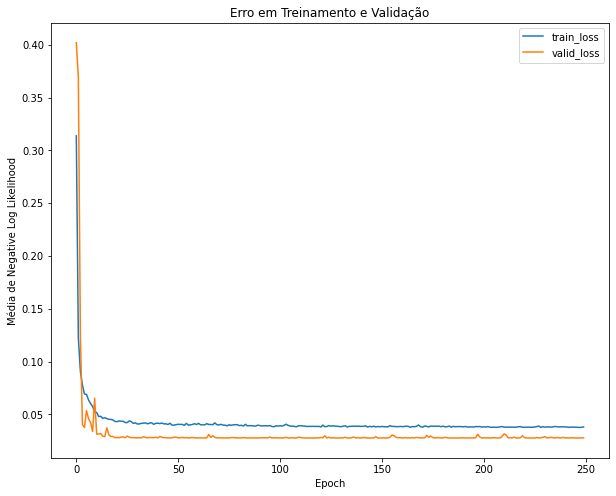

In [33]:
# Plot
plt.figure(figsize = (10, 8))
for c in ['train_loss', 'valid_loss']:
    plt.plot(history[c], label = c)
plt.legend()
plt.xlabel('Epoch', color = 'k')
plt.ylabel('Média de Negative Log Likelihood')
plt.title('Erro em Treinamento e Validação')

### Salva o Modelo

In [34]:
checkpoint_path = 'modelos/resnet50-transfer.pth'

In [35]:
# Função para salvar o modelo
def save_checkpoint(model, path):

    checkpoint = {'epochs': model.epochs}
    checkpoint['fc'] = model.fc
    checkpoint['state_dict'] = model.state_dict()

    # Adiciona o otimizador
    checkpoint['optimizer'] = model.optimizer
    checkpoint['optimizer_state_dict'] = model.optimizer.state_dict()
    
    torch.save(checkpoint, path)

In [36]:
save_checkpoint(modelo, path = checkpoint_path)

### Testa o Modelo Treinado com Novos Dados

In [37]:
# Função de cálculo da métrica
def check_mse_on_test(model, testloader, criterion = None, device = 'cpu'):  

    loss = 0
    test_loss = 0
    std_mean = 0
    model.eval()
    test_dataframe = pd.read_csv(test_filename)
    
    with torch.no_grad():
        
        for data, target in testloader:
            
            if train_on_gpu:
                data, target = data.cuda(), target.cuda()
            output = model(data)

            test_dataframe ['predicted output'] = np.squeeze(output.cpu().numpy())
            test_dataframe.to_csv("dados/pred_test_file.csv", index = False, encoding = 'utf8')

            std_mean = torch.std_mean(output)
            loss = criterion(output, target.float())
            
            # Multiply average loss times the number of examples in batch
            test_loss += loss.item() * data.size(0)
            
    return std_mean , test_loss / len(testloader.dataset)

In [38]:
criterion = nn.L1Loss()

In [39]:
# Extrai desvio padrão e erro com dados de teste
std_mean , test_loss = check_mse_on_test(modelo, dataloaders['test'], criterion, device = 'cuda')

In [40]:
print('Dados de Teste - MAE Loss = {:.4f} '.format(test_loss))
print('Dados de Teste - Desvio Padrão de HC =  {:.4f} mm'.format(std_mean[0] * 346.4))
print('Dados de Teste - MAE Loss de HC = {:.4f} mm'.format(test_loss * 346.4))

Dados de Teste - MAE Loss = 0.1276 
Dados de Teste - Desvio Padrão de HC =  1.8626 mm
Dados de Teste - MAE Loss de HC = 44.1867 mm
